In [3]:
import pandas as pd


housing = pd.read_csv("datasets/housing/housing.csv")
print(housing.head())
print(housing.info())

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639

In [4]:
# create a test set
import numpy as np
np.random.seed(42)

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(housing, 0.2)

income_cat
3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: count, dtype: float64

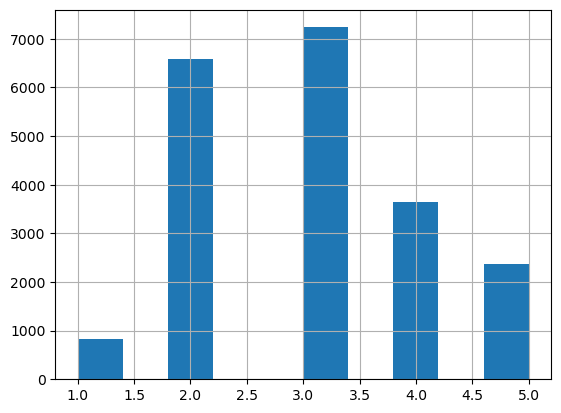

In [5]:
# split housing into income categories and stratify based on median income
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

housing["income_cat"].hist()

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

strat_test_set["income_cat"].value_counts() / len(strat_test_set)

housing["income_cat"].value_counts() / len(housing)

In [6]:
# prepare for machine learning
housing = strat_train_set.drop("median_house_value", axis=1) 
housing_labels = strat_train_set["median_house_value"].copy()

# data cleaning
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

housing_num = housing.drop("ocean_proximity", axis=1)

imputer.fit(housing_num)
X = imputer.transform(housing_num)

housing_tr = pd.DataFrame(X, columns=housing_num.columns)
housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   income_cat          16512 non-null  float64
dtypes: float64(9)
memory usage: 1.1 MB


In [7]:
# handling categorical attribute ocean_proximity

housing_cat = housing[["ocean_proximity"]]

from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [8]:
# creating a custom transformer to add additional attributes

from sklearn.base import BaseEstimator, TransformerMixin

# get the right column indices: safer than hard-coding indices
col_names = "total_rooms", "total_bedrooms", "population", "households"
rooms_ix, bedrooms_ix, population_ix, households_ix = [
    housing.columns.get_loc(c) for c in col_names]

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    # initialize and take in extra hyperparameter to decide whether to add bedrooms_per_room
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    # we need a fit method to satisfy the TransformerMixin, but it doesn't do anything in this case
    # just reurns the transformer instance (self)
    def fit(self, X, y=None):
        return self
    # now we implement the transform method itself in order to add the new attributes
    # X is the dataset to be transformed
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns) + ["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat,rooms_per_household,population_per_household
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND,2,5.485836,3.168555
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN,5,6.927083,2.623698
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.875,INLAND,2,5.393333,2.223333
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN,2,3.886128,1.859213
20496,-118.7,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN,3,6.096552,3.167241


In [9]:
# now we can define a transformation pipeline to handle all the transformations in the right order

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [10]:
# we can use the ColumnTransformer to apply the transformations to the numerical and categorical columns
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing)

In [11]:
# we will now start by training a linear regression model

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

# let's try the model on some instances from the training set
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [ 83712. 315584. 145792. 184576. 238016.]


In [12]:
print("Labels:", list(some_labels))

Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [13]:
# lets check the RMSE on the whole training set
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68380.70036286271

In [14]:
# now we will try a decision tree regressor
# it is capable of finding complex nonlinear relationships in the data, making it a more powerful model compared to linear regression

from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)

# let's check the RMSE again
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [15]:
# okay a RMSE of 0.0 is too good to be true, we are likely overfitting the data, lets use cross-validation to get a better estimate
# cross validation splits the training set into 10 distinct subsets called folds, then it trains and evaluates the model 10 times
# picking a different fold for evaluation every time and training on the other 9 folds
# the result is an array containing the 10 evaluation scores
# this will hopefully reduce the overfitting

from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                            scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [72911.75619588 70534.64719643 68056.82124274 71737.5750205
 70068.57116663 76145.99314244 71333.91880406 71930.72225522
 67366.33320212 70811.07718006]
Mean: 71089.74154060845
Standard deviation: 2335.87081532474


In [19]:
# next we will try a random forest regressor
# it works by training a number of decision tree regressors on random subsets of the training set hence the name random forest (many tree regressors)

from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

housing_predictions = forest_reg.predict(housing_prepared)

# let's check the RMSE again
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse



18675.224916252282

In [20]:
# lets use cross-validation to get a better estimate again

from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)

forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [51553.65292335 48797.89565614 47005.23947642 52046.73567245
 47700.78025873 51824.08544879 52582.59165129 49949.79025967
 48680.25622229 54019.67674791]
Mean: 50416.070431704204
Standard deviation: 2201.612779754884


In [23]:
# lastly we will try a support vector regressor
# at first using the default hyperparameters and a linear kernel

from sklearn.svm import SVR

svm_reg_lin = SVR(kernel="linear")
svm_reg_lin.fit(housing_prepared, housing_labels)

housing_predictions = svm_reg_lin.predict(housing_prepared)

# let's check the RMSE again
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

106873.526604078

In [24]:
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_reg_lin, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)

svm_rmse_scores = np.sqrt(-svm_scores)
display_scores(svm_rmse_scores)

Scores: [106846.91418486 108840.55721006 103122.02433423 109649.5401006
 103796.57205905 112219.65143015 109351.47147536 107877.83853403
 109166.01514235 108053.90140047]
Mean: 107892.44858711655
Standard deviation: 2590.6419916301343


In [27]:
# that seems bad, let's try a different kernel

svm_reg_rbf = SVR(kernel="rbf")
svm_reg_rbf.fit(housing_prepared, housing_labels)

housing_predictions = svm_reg_rbf.predict(housing_prepared)

svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

118451.153930123

In [28]:
svm_scores = cross_val_score(svm_reg_rbf, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)

svm_rmse_scores = np.sqrt(-svm_scores)
display_scores(svm_rmse_scores)

Scores: [116628.19183878 119988.26365356 113823.78366263 120271.03189229
 114581.92489539 122665.05912251 119753.16461411 118174.92428728
 120129.13952467 118707.9580594 ]
Mean: 118472.3441550637
Standard deviation: 2603.593039791196


In [29]:
# use the grid search to find the best parameters for svm

from sklearn.model_selection import GridSearchCV

param_grid = [
    {'kernel': ['linear'], 'C': [10., 100., 1000., 10000., 30000.0]},
    {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
     'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]}
]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [10.0, 100.0, 1000.0, 10000.0, 30000.0],
                          'kernel': ['linear']},
                         {'C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0],
                          'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                          'kernel': ['rbf']}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [30]:
# lets check the rmse
negative_mse = grid_search.best_score_

rmse = np.sqrt(-negative_mse)
rmse

70279.3095484106

In [31]:
grid_search.best_params_

{'C': 1000.0, 'kernel': 'linear'}

In [33]:
# in order to compare SVR with RandomForestRegressor we will plot the predictions against the actual values

svm_reg = SVR(C=1000.0, kernel='linear')
svm_reg.fit(housing_prepared, housing_labels)
predictions_svm = svm_reg.predict(housing_prepared)

svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

predictions_forest = forest_reg.predict(housing_prepared)


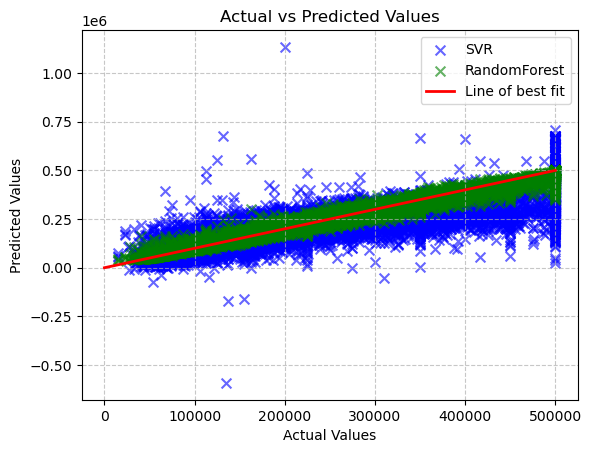

In [64]:
import matplotlib.pyplot as plt


# Scatter plot for SVR predictions
plt.scatter(housing_labels, predictions_svm, c='blue', marker='x', label='SVR', alpha=0.6, s=50)

# Scatter plot for RandomForest predictions
plt.scatter(housing_labels, predictions_forest, c='green', marker='x', label='RandomForest', alpha=0.6, s=50)

# Line of best fit
plt.plot([0, 500000], [0, 500000], 'r', lw=2, label='Line of best fit')

plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.show()